In [1]:
import torch
import torch.nn as nn
import PIL
import cv2
import argparse
import numpy as np
import os
import time
import copy
import glob
from tqdm import tqdm
from pathlib import Path
import torchvision
import torchvision.transforms as T
from yolov5_face_detect import *
from models.experimental import attempt_load
from utils.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from utils.extract_features import extract_features
from utils.torch_utils import select_device
from evaluation.feature_inversion_loss import face_loss
from evaluation.SSIM_score import SSIM_score
from imageio import imread
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# multi-gpu
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# print('Device:', device, '/Name:', torch.cuda.get_device_name())
# print('Count of using GPUs:', torch.cuda.device_count())
# print('Current cuda device:', torch.cuda.current_device())

In [3]:
# Load the pre-trained SqueezeNet model. (imagenet pretrained)
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.to(device)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.

for param in cnn.parameters():
    param.requires_grad = False

In [4]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),                                           
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def preprocess_rand(img):
    transform = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess_rand(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]), 
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x): # MINMAX Standardization
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [19]:
def face_blur_single(image, distort_weight, fade_weight, save_folder=None, weights='./weights/face_l.pt', img_size=640, conf_thres=0.5, iou_thres=0.5,
                     iteration=400, device='0', eval = False, circle = True):
    
    """
    Explain

    - Adjusted_params
    > > image(single): type=numpy.ndarray help=image to make blur : content_image
    > > distort_weight: type=int, default=1, help=(1~5) As the weight increases, the face becomes increasingly distorted.
    > > fade_weight: type=int, default=1, help=(1~5) As the weight increases, the face gradually fades.
    > > dataset_folder(default): type=str, help=original content face images directory


    - Additional_params
    > > save_folder: type=str, default=None, help=directory to save blur images
    > > weights: type=str, default='./weights/face_l.pt', help=(face_detector)_model.pt path(s)
    > > img_size: type=int, default=640, help=(face_detector)_inference size (pixels)
    > > conf_thres: type=float, default=0.5, help=(face_detector)_object confidence threshold
    > > iou_thres:  type=float, default=0.5, help=(face_detector)_IOU threshold for NMS
    > > iteration: type=int, default=400, help=how many iterations to feature-inversion
    > > device: type=str, default='0', help=cuda device, i.e. 0 or 0,1,2,3 or cpu
    > > eval: type=str, default=False, help=show various evaluation tools : blur_image, inference_time, cos_similarity, de-identification value(SSIM)
    > > circle: type=bool, default=True, help=blur face in shape of circle or rectangle, if False, its rectangle
    """


    if eval:
        #time check
        start_time = time.time()
    
    # Load model
    device = select_device(device)
    model = attempt_load(weights, map_location=device)  # load FP32 model
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 0.9*iteration

    # Blur hyperparameters
    
    if distort_weight > 5: # error exception
        distort_weight = 5
    elif distort_weight < 1:
        distort_weight = 1
    
    if fade_weight > 5: # error exception
        fade_weight = 5
    elif fade_weight < 1:
        fade_weight = 1
        
    fade_dict = {1: 3e11, 2: 7e11, 3: 1e12, 4: 5e12, 5: 9e12}
    distort_dict = {1: 5, 2: 6, 3: 7, 4: 8, 5: 9}
    target_layer = distort_dict[distort_weight] #target_layer, the layer that do inverse feature from
    
    #-------------------------------
    
    if eval:
        #time check
        infer_start_time = time.time()

    imgC = image  # imgC: Content-original_images

    #Record original image size
    h, w, _ = imgC.shape

    #yolov5_face_detect
    boxes = detect(model, imgC, img_size, conf_thres, iou_thres, device)
    
    # bounding box list
    bbox_list = []

    imgB = copy.deepcopy(imgC) #Copy, imgB: Blur-images
    for box in boxes:

        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[0]) + int(box[2])
        y2 = int(box[1]) + int(box[3])

        # bounding box
        bbox_list.append( (x1,y1,x2,y2) )
        
        if circle:
            ####### eclipse ########
            #center (x,y)
            x = (x1+x2)//2
            y = (y1+y2)//2

            #long_axis, short_axis
            l = round((y2-y1)*(9/16))
            s = round((x2-x1)*(5/8))

            #make eclipse mask
            mask = np.zeros((h,w), dtype=np.int8)
            cv2.ellipse(mask, (x, y), (l, s), 90, 0, 360, (1,1,1), -1)

            # delete face bounding circle
            imgB = imgB - imgB*mask[...,np.newaxis]

            # synthesize blur face circle
            random = np.array(np.random.uniform(low=0, high=255, size=(h, w, 3)), dtype='uint8')# 0~255
            imgB = imgB + random*mask[...,np.newaxis]
            
        else:
            ######rectangle######
            # delete face bbox
            imgB[y1:y2, x1:x2, :] -= imgB[y1:y2, x1:x2, :]

            #synthesize uniform random noise
            imgB[y1:y2, x1:x2, :] += np.array(np.random.uniform(low=0, high=255, size=(y2-y1, x2-x1, 3)), dtype='uint8')

    # numpy(cv2) -> torch.Tensor | Resize(512) | Normalize(squeeze_mean, squeeze_std)
    imgC = preprocess(PIL.Image.fromarray(imgC))
    imgB = preprocess(PIL.Image.fromarray(imgB.astype(np.uint8)))

    # Extract Zero(original)_image feature
    featsC = extract_features(imgC, cnn, device=device)

    #Assign imgB on auto_graph (parameter)
    imgB = imgB.to(device).requires_grad_()

    #Optimizer
    optimizer = torch.optim.Adam([imgB], lr=initial_lr)

    #Feature-Inversion in times of iteration
    for t in range(iteration):

        #Initialize weight
        optimizer.zero_grad()

        #(lr_scheduling) 0.9*iteration이면, lr를 0.1으로 스케줄링
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([imgB], lr=decayed_lr) 

        #(Clamping) 0.95*iteration이면, imgB weight bound in (-1.5, 1.5) -> nonlinearity like relu
        if t < 0.95*iteration:
            imgB.data.clamp_(-1.5, 1.5)

        # Extract updated Blur_image feature
        featsB = extract_features(imgB, cnn, device=device)

        # Loss
        loss = face_loss(fade_dict[fade_weight], featsB[target_layer], featsC[target_layer])

        # update the amount of loss
        loss.backward()
        optimizer.step()
    
    if eval:
        #Cos-sim btw blur_image, Content_image of target_layer
        cos = torch.nn.CosineSimilarity(dim=0)
        cos_sim = cos(torch.flatten(featsB[target_layer]), torch.flatten(featsC[target_layer]))

    #Blur_result (torch.Tensor -> np.array)& Back to original size
    imgB_result = T.functional.resize(deprocess(imgB.detach().cpu()), size=(h,w), interpolation= torchvision.transforms.functional.InterpolationMode.LANCZOS) # Auto_graph에서 내리자
    imgB_result = np.asarray(imgB_result) #asarray를 써서 데이터형태가 같은 경우, 메모리 같은 곳 사용(메모리 절약)

    #Blur faces+ Content background (torch.Tensor -> np.array)& Back to original size
    imgD = T.functional.resize(deprocess(imgC), size=(h,w), interpolation= torchvision.transforms.functional.InterpolationMode.LANCZOS) # Lanczos 보간법 (8x8 이웃 픽셀 참조)
    imgD = np.asarray(imgD)

    #De-identification btw Blur_faces, Content_faces
    de_identifi=0
    for bbox in bbox_list:
        
        if eval:
            #imgD == imgC for now
            de_identifi += 1 - SSIM_score(original_crop = PIL.Image.fromarray(imgD[bbox[1]:bbox[3], bbox[0]:bbox[2], :].astype(np.uint8)), 
                                          generate_crop = PIL.Image.fromarray(imgB_result[bbox[1]:bbox[3], bbox[0]:bbox[2], :].astype(np.uint8)),
                                          device=device)
        if circle:
            ####### eclipse ######
            #center (x,y)
            x = (bbox[0]+bbox[2])//2
            y = (bbox[1]+bbox[3])//2

            #long_axis, short_axis
            l = round((y2-y1)*(9/16))
            s = round((x2-x1)*(5/8))

            #make eclipse mask
            mask = np.zeros((h,w), dtype=np.int8)
            cv2.ellipse(mask, (x, y), (l, s), 90, 0, 360, (1,1,1), -1)

            # delete face bounding circle
            imgD = imgD - imgD*mask[...,np.newaxis]

            # synthesize blur face circle
            imgD = imgD + imgB_result*mask[...,np.newaxis]

        else:
            ######rectangle######
            # delete face bbox
            imgD[bbox[1]:bbox[3], bbox[0]:bbox[2], :] -= imgD[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

            # synthesize blur result faces
            imgD[bbox[1]:bbox[3], bbox[0]:bbox[2], :] += imgB_result[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

    # np.array -> PIL.Image
    imgD = PIL.Image.fromarray(imgD.astype(np.uint8))

    # Extract Blur faces+ Content images
    featsD = extract_features(preprocess(imgD), cnn, device=device)
    
    if eval:
        
        de_identification = de_identifi/len(bbox_list) #mean of faces
        
        #Cos-sim btw target_layer feature of squeezenet
        cos_sim_target = cos(torch.flatten(featsD[target_layer]), torch.flatten(featsC[target_layer]))
        
#         #Cos-sim btw output feature of squeezenet
#         cos_sim_out = cos(torch.flatten(featsD[-1]), torch.flatten(featsC[-1]))
    
        # Output(Content-original& Blur)
        f, axarr = plt.subplots(1,2, figsize=(10, 20))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[0].set_title('Original img.')
        axarr[1].set_title('Blur img.')
        axarr[0].imshow(deprocess(imgC)) # De-normalize (torch.Tensor -> PIL.Image)
        axarr[1].imshow(imgD) 
        plt.show()
    
        # 학습 정도-해당 층의 feature 유사도
        print(f"학습 정도-해당 층 feature (코사인)유사도(%): {cos_sim*100:.1f}")

        # 검색 성능 지표-CNN(squeezenet) output feature 유사도(imgD, imgC)
        print(f"검색 지표-CNN(squeezenet) feature (코사인)유사도(%): {cos_sim_target*100:.1f}")
        # 비식별화 값의 평균 (탐지된 얼굴들)
        print(f"비식별 값(1-SSIM)(%): {de_identification*100:.1f}")

        #Inference time of a image
        print(f"걸린 시간: {time.time() - infer_start_time: .2f}s")
        print(f'--------------------------------------------------')

    #Save
    if save_folder is None:
        pass
    else:
        os.makedirs(f"{save_folder}/", exist_ok=True)
        imgD.save(f'{save_folder}/blur_d{distort_weight}-f{fade_weight}-c{cos_sim_target*100:.1f}-s{de_identification*100:.1f}.jpg', 'JPEG')
    
    print('done.')
    
    return np.asarray(imgD) #dtype = np.array

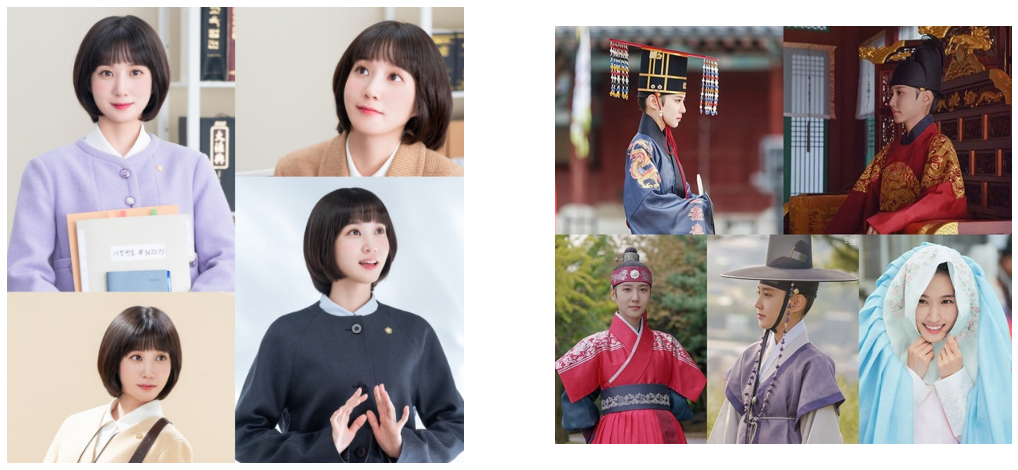

In [20]:
#test_img
test1_img = cv2.imread('./data/img/eunbin.png')
test1_img=cv2.cvtColor(test1_img, cv2.COLOR_BGR2RGB)

test2_img = cv2.imread('./data/img/eunbin2.jpg')
test2_img=cv2.cvtColor(test2_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,2, figsize=(18,20))
ax = axes.flatten()
ax[0].imshow(test1_img)
ax[1].imshow(test2_img)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Fusing layers... 


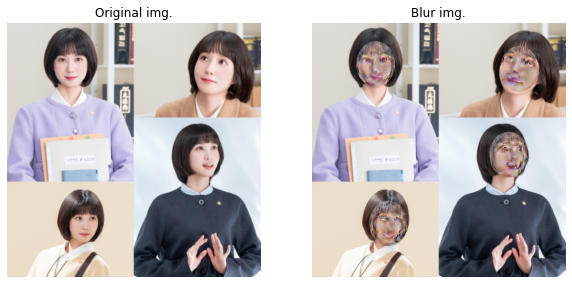

학습 정도-해당 층 feature (코사인)유사도(%): 97.4
검색 지표-CNN(squeezenet) feature (코사인)유사도(%): 98.1
비식별 값(1-SSIM)(%): 87.1
걸린 시간:  2.17s
--------------------------------------------------
done.


In [25]:
# make blur1_img
blur1_img = face_blur_single(test1_img, distort_weight=2, fade_weight=3, eval=True, save_folder='./data/result/')

Fusing layers... 


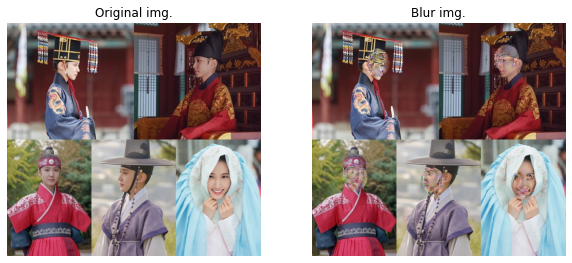

학습 정도-해당 층 feature (코사인)유사도(%): 99.4
검색 지표-CNN(squeezenet) feature (코사인)유사도(%): 98.7
비식별 값(1-SSIM)(%): 87.6
걸린 시간:  2.31s
--------------------------------------------------
done.


In [30]:
# make blur2_img
blur2_img = face_blur_single(test2_img, distort_weight =2, fade_weight=3, eval=True, save_folder='./data/result/')

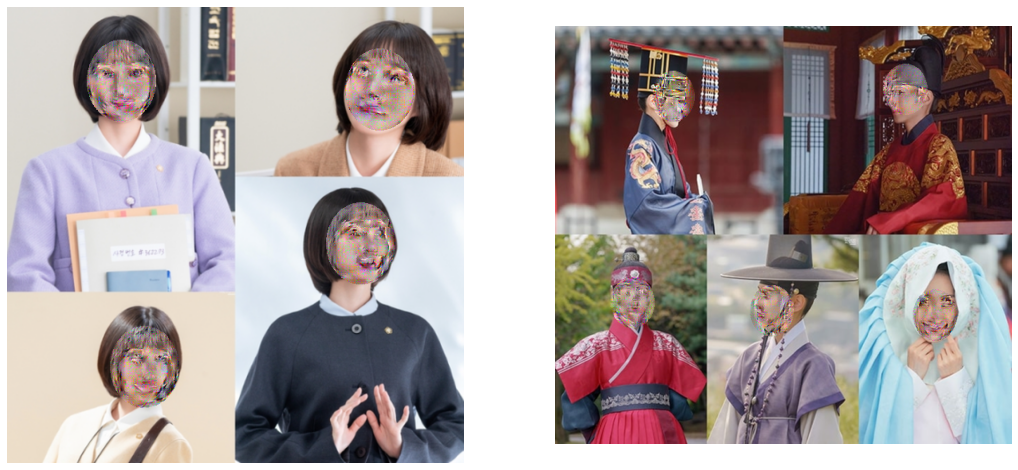

In [31]:
#blur_img
fig, axes = plt.subplots(1,2, figsize=(18,20))
ax = axes.flatten()
ax[0].imshow(blur1_img)
ax[1].imshow(blur2_img)
ax[0].axis('off')
ax[1].axis('off')
plt.show()